Attempt to optimize the model by increasinf the the number of neuros in the bottleneck layer from 2 (Autoencoders_Grade3.ipynb) to 8.

The performance is slightly better, however, as the autoencoder is more complex it requires more computational time. Hence the initial approach could be considered as the differences are than big.

In [ ]:
#Mount personal Google Drive to colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/UU/AI_for_IA/Autoencoders')

Mounted at /content/drive


In [ ]:
#Import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors
from torch.utils.data import random_split

In [ ]:
#Set the parameters
random_seed = 49
learning_rate = 0.0005
num_epochs = 30
batch_size = 256
num_classes = 10

#Download MNIST dataset
def get_mnist(batch_size, num_workers=0, train_transforms=None, test_transforms=None):

  #Set the type of transformers if not defined to tensor
  if train_transforms == None:
    train_transforms = transforms.ToTensor()
  if test_transforms == None:
    test_transforms = transforms.ToTensor()

  #Download data
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
  #valid_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=test_transforms)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

  train_size = int(0.8 * len(train_dataset))  #80% for training
  valid_size = len(train_dataset) - train_size  #20% for validation

  train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

  #Create dataloader
  train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
  valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = len(valid_dataset), shuffle = False, num_workers = num_workers)
  test_dataloader = DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = False, num_workers = num_workers)

  return train_dataloader, valid_dataloader, test_dataloader

train_loader, valid_loader, test_loader = get_mnist(batch_size)
print(len(train_loader), len(valid_loader), len(test_loader))

188 1 1


In [ ]:
#Define the class model autoencoder

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class Autoencoder_opt(nn.Module):

  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding = 1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding = 1),
        nn.Flatten(),
        nn.Linear(3136, 8)
    )

    self.decoder = nn.Sequential(
        torch.nn.Linear(8, 3136),
        Reshape(-1, 64, 7, 7), #alternatice  nn.Unflatten(1, (64, 7, 7)),
        nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size= (3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size= (3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size= (3, 3), padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32, 1, stride=(2, 2), kernel_size= (3, 3), padding=0),
        Trim(), #alternative with pytorch nn.CenterCrop((28, 28)),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):

  total_loss = 0.0
  num_batches = len(data_loader)

  #Loop through each batch in the data loader
  for features, _ in data_loader:

    logits = model(features)
    batch_loss = loss_fn(logits, features)
    total_loss += batch_loss.item()

    #Calculate the average loss across all batches in the epoch
  epoch_loss = total_loss / num_batches
  return epoch_loss

In [ ]:
#Training of the autoencoder

def train_autoencoder(num_epochs, model, optimizer,
                         train_loader, valid_loader,
                         loss_fn=None,
                         logging_interval=50,
                         skip_epoch_stats=None,
                         save_model=None):

  log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': [],
                'valid_loss_per_epoch': []}
  if loss_fn is None:
    loss_fn = F.mse_loss # Default to MSE loss if not provided

  start_time = time.time()

  for epoch in range(num_epochs):
    model.train() # Set the model to training mode

    for batch_idx, (features, _) in enumerate(train_loader):
      #FORWARD AND BACK PROPAGATION
      logits = model(features) # Pass features through the model
      loss = loss_fn(logits, features) # Calculate loss
      optimizer.zero_grad() # Reset gradients
      loss.backward() # Calculate gradients
      #UPDATE MODEL PARAMETERS
      optimizer.step() # Update model parameters

      #LOGGING
      log_dict['train_loss_per_batch'].append(loss.item())
      if not batch_idx % logging_interval:
        print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
        % (epoch+1, num_epochs, batch_idx,
            len(train_loader), loss))

    #EPOCH-LEVEL STATISTICS (optional)
    if not skip_epoch_stats:
      model.eval() # Set the model to evaluation mode
      with torch.set_grad_enabled(False):  # Save memory during inference
          train_loss = compute_epoch_loss_autoencoder(model, train_loader, loss_fn) # Calculate epoch loss
          valid_loss = compute_epoch_loss_autoencoder(model, valid_loader, loss_fn)
          print('***Epoch: %03d/%03d | Train Loss: %.3f  | Valid Loss: %.3f' % (epoch+1, num_epochs, train_loss, valid_loss))
          log_dict['train_loss_per_epoch'].append(train_loss)
          log_dict['valid_loss_per_epoch'].append(valid_loss)

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  #SAVE MODEL (optional)
  if save_model is not None:
    torch.save(model.state_dict(), save_model) # Save model weights
  return log_dict


#Training of the autoencoder
learning_rate = 0.0005
num_epochs = 30
model_opt = Autoencoder_opt()
optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=learning_rate)
loss_fn_opt = nn.MSELoss()

#train_loader, valid_loader, test_loader = get_mnist(batch_size)
autoencoder_log_dict_opt = train_autoencoder(num_epochs, model_opt, optimizer_opt, train_loader, valid_loader, loss_fn_opt, save_model="./autoencoder_opt_weights.pth")

#Save log
np.save('autoencoder_log_dict_opt.npy', autoencoder_log_dict_opt)

Epoch: 001/030 | Batch 0000/0188 | Loss: 0.1871
Epoch: 001/030 | Batch 0050/0188 | Loss: 0.0709
Epoch: 001/030 | Batch 0100/0188 | Loss: 0.0653
Epoch: 001/030 | Batch 0150/0188 | Loss: 0.0649
***Epoch: 001/030 | Train Loss: 0.062  | Valid Loss: 0.062
Time elapsed: 5.78 min
Epoch: 002/030 | Batch 0000/0188 | Loss: 0.0635
Epoch: 002/030 | Batch 0050/0188 | Loss: 0.0471
Epoch: 002/030 | Batch 0100/0188 | Loss: 0.0351
Epoch: 002/030 | Batch 0150/0188 | Loss: 0.0263
***Epoch: 002/030 | Train Loss: 0.028  | Valid Loss: 0.028
Time elapsed: 10.99 min
Epoch: 003/030 | Batch 0000/0188 | Loss: 0.0274
Epoch: 003/030 | Batch 0050/0188 | Loss: 0.0263
Epoch: 003/030 | Batch 0100/0188 | Loss: 0.0252
Epoch: 003/030 | Batch 0150/0188 | Loss: 0.0235
***Epoch: 003/030 | Train Loss: 0.024  | Valid Loss: 0.024
Time elapsed: 16.28 min
Epoch: 004/030 | Batch 0000/0188 | Loss: 0.0246
Epoch: 004/030 | Batch 0050/0188 | Loss: 0.0239
Epoch: 004/030 | Batch 0100/0188 | Loss: 0.0228
Epoch: 004/030 | Batch 0150/0188

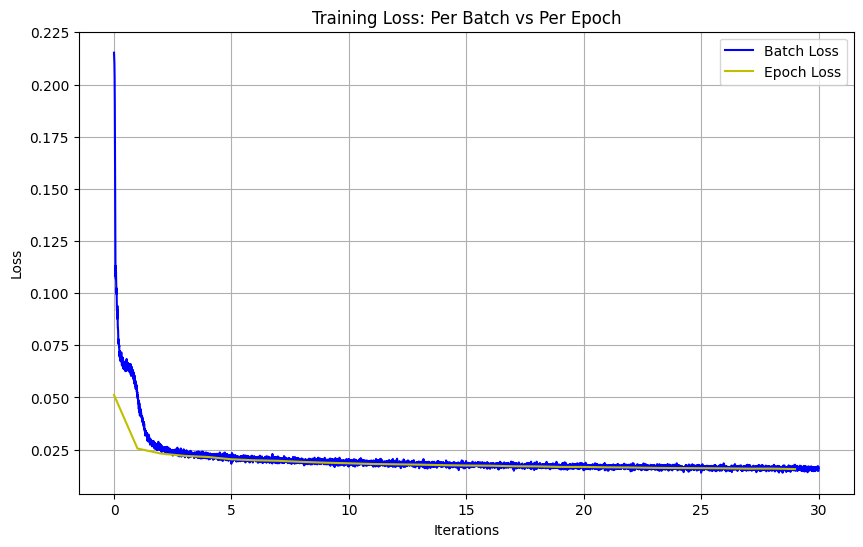

In [ ]:
#Plot the errors
#print(autoencoder_log_dict_opt)

# Assume autoencoder_log_dict_opt contains the losses
train_loss_per_epoch = autoencoder_log_dict_opt['train_loss_per_epoch']
train_loss_per_batch = autoencoder_log_dict_opt['train_loss_per_batch']
valid_loss_per_epoch = autoencoder_log_dict_opt['valid_loss_per_epoch']

# Number of batches per epoch
num_batches_per_epoch = 235
num_epochs = len(train_loss_per_epoch)

# Create x-axis for batch losses: fractional epochs
x_batch = np.linspace(0, num_epochs, len(train_loss_per_batch))

# Create x-axis for epoch losses: full integers
x_epoch = np.arange(0, num_epochs)

# Create x-axis for validation
x_valid = np.arange(0, num_epochs)

# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(x_batch, train_loss_per_batch, c='b', label='Batch Loss')
plt.plot(x_epoch, train_loss_per_epoch, c='y', label='Epoch Loss',)
plt.plot(x_valid, valid_loss_per_epoch, c='r', label='Validation Loss')

# Add labels and legend
plt.title('Training Loss: Per Batch vs Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

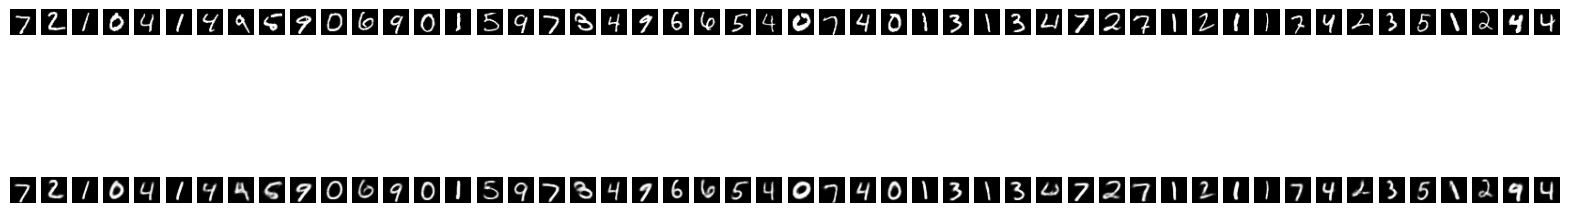

In [ ]:
#Reconstruction of images on test set
def plot_reconstruction(model, data_loader, num_samples=20):
  model.eval()
  with torch.no_grad():
    for i, (images, _) in enumerate(data_loader):
      if i >= num_samples:
        break
        # Forward pass
      reconstructed = model(images)

      # Plot the original and reconstructed images
      fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
      for j in range(num_samples):
        axes[0, j].imshow(images[j].squeeze(), cmap='gray')
        axes[0, j].axis('off')
        axes[1, j].imshow(reconstructed[j].squeeze(), cmap='gray')
        axes[1, j].axis('off')
      plt.show()

plot_reconstruction(model_opt, test_loader, 50)

Reducing dimensions with PCA...


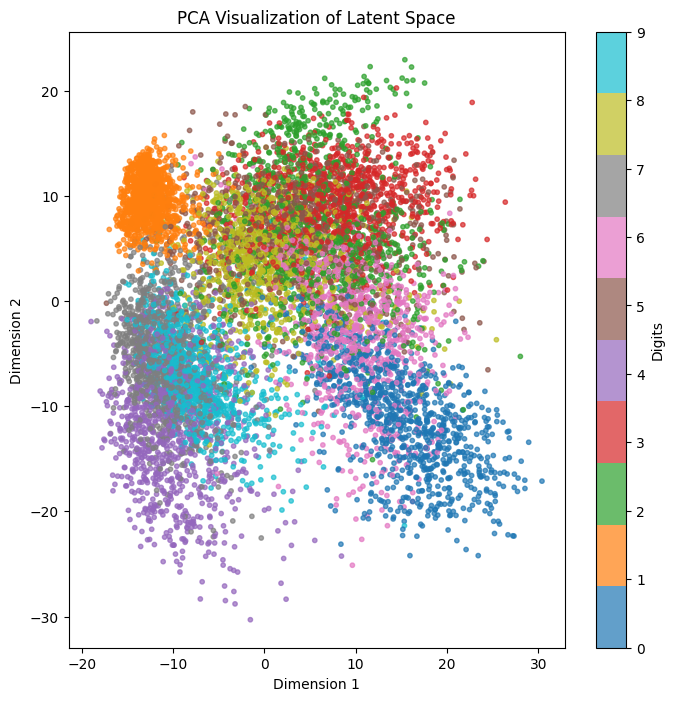

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Visualize a high-dimensional latent space (e.g., 8D) using t-SNE or PCA.
def plot_latent_space_highdim(model, data_loader, num_batches=None, method='tsne'):
    model.eval()  # Set model to evaluation mode
    all_latents = []
    all_labels = []

    # Extract the latent space
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            latents = model.encoder(images)
            all_latents.append(latents.cpu().numpy())  # Move to CPU
            all_labels.append(labels.cpu().numpy())
            if num_batches is not None and i >= num_batches - 1:
                break

    # Concatenate all batches
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Standardize the latent representations
    scaler = StandardScaler()
    scaled_latents = scaler.fit_transform(all_latents)

    # Dimensionality reduction
    if method == 'tsne':
        print("Reducing dimensions with t-SNE...")
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        print("Reducing dimensions with PCA...")
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")

    latents_2d = reducer.fit_transform(all_latents)

    # Scatter plot
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(10), label="Digits")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(f'{method.upper()} Visualization of Latent Space')
    plt.show()

plot_latent_space_highdim(model_opt, test_loader, method='pca')